In [1]:
!pip install proxbias --quiet

import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import Bunch

from proxbias import utils as utils
import proxbias as pb

# This is necesary for the svg output plots to have editable text
plt.rcParams['svg.fonttype'] = 'none'

# Just to make the notebook take up full screen real estate, not necessary
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Functions -- TODO move to repo

In [2]:
from typing import List, Tuple

# cnv_loss_cutoff = 0.805  # 0.6 copies and below
# cnv_gain_cutoff = 1.026  # 3.8 copies and above
cnv_absolute_loss_cutoff = 1.5
cnv_absolute_gain_cutoff = 2.25

def split_models(
    gene_symbol: str,
    candidate_models: List[str],
    cnv_data: pd.DataFrame,
    mutation_data: pd.DataFrame,
    cutoffs: Tuple[float, float] = (cnv_absolute_loss_cutoff, cnv_absolute_gain_cutoff),
) -> Tuple[List[str], List[str], List[str], List[str]]:
    mutant_lines = mutation_data.loc[(
        (mutation_data["HugoSymbol"] == gene_symbol) &
        (~mutation_data["VariantInfo"].isna()) # Not using the mutant type information
    ),'ModelID'].unique().tolist()
    wild_type = list(set(candidate_models).difference(mutant_lines))
    mutants = list(set(candidate_models).difference(wild_type))

    cnv_subset = (np.power(2, cnv_data.loc[gene_symbol]) - 1) * 2
    # wt_cnv = cnv_subset.loc[cnv_subset.index.intersection(wild_type)]
    all_cnv = cnv_subset.loc[cnv_subset.index.intersection(candidate_models)]
    lof = list(set(candidate_models).intersection(all_cnv.loc[all_cnv < cutoffs[0]].index.unique()))
    gof = list(set(candidate_models).intersection(all_cnv.loc[all_cnv >= cutoffs[1]].index.unique()))
    mutant_low_change = set(candidate_models).difference(set(lof) | set(gof) | set(wild_type))
    wt_low_change = set(wild_type).difference(set(lof) | set(gof))
    return list(lof), list(wt_low_change), list(gof), list(mutant_low_change)

# Load in DepMap cell line annotation data (CNV & mutations)


In [3]:
data_dir = '../data'
cnv_file = os.path.join(data_dir, "OmicsCNGene.csv")
cnv_data = pd.read_csv(cnv_file).rename(columns={"Unnamed: 0": "ModelID"}).set_index("ModelID").T
cnv_data.index = [g.split(" ")[0] for g in cnv_data.index]  # remove entrez gene ids

mutation_file = "OmicsSomaticMutations.csv"
mutation_data = pd.read_csv(os.path.join(data_dir, mutation_file)).rename(columns={"DepMap_ID": "ModelID"})

/tmp/ipykernel_1159160/924039965.py:7: DtypeWarning: Columns (32,40,48,49,50,51,53) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_data = pd.read_csv(os.path.join(data_dir, mutation_file)).rename(columns={"DepMap_ID": "ModelID"})


# Load in the 22Q4 DepMap data 

See notes in the README on how to download and process this data.

In [39]:
dm22q4 = pd.read_csv(os.path.join(data_dir, 'depmap_22q4_embeddings.csv'), index_col='Unnamed: 0')
dm22q4.index.name = 'display_label'

In [40]:
dm22q4.head(2)

,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-002283,ACH-002284,ACH-002285,ACH-002294,ACH-002295,ACH-002296,ACH-002297,ACH-002298,ACH-002304,ACH-002305
display_label,,,,,,,,,,,,,,,,,,,,,
SAMD11,0.138971,-0.024604,0.164436,-0.135659,0.181989,-0.007635,0.050045,-0.001966,0.05847,-0.058567,...,0.132243,-0.130717,-0.148272,0.133393,-0.030585,0.042350,0.046475,0.086503,-0.05088,0.187428
NOC2L,-0.337622,0.298930,-0.277252,-0.199345,0.045464,-0.445447,0.153700,-0.053124,0.14612,-0.107405,...,-0.033149,-0.023406,-0.285678,0.009905,-0.110960,-0.309166,-0.058206,-0.188165,-0.59778,0.065761


# Add in chromosome position information

In [11]:
gene_dict, chrom_dict, band_dict = utils.chromosome_info.get_chromosome_info_as_dicts()
genes = list(gene_dict.keys())

In [41]:
# Subset to genes with chrom information from hg38
idx = dm22q4.query(f"display_label.isin({genes})").index
print(f'Full data has {dm22q4.shape[0]} genes, {len(idx)} of which are in annotations')
dm22q4 = dm22q4.loc[idx]

# Add in chromomsome information
def _add_chr_info(df, gene_dict, in_nm, out_nm):
    df[out_nm] = dm22q4.index.to_frame().display_label.apply(lambda x: gene_dict[x][in_nm] if x in gene_dict else "no_info")
    return df

old_cols = dm22q4.columns.tolist()
dm22q4 = _add_chr_info(dm22q4, gene_dict, 'chrom', 'chromosome')
dm22q4 = _add_chr_info(dm22q4, gene_dict, 'chrom_int', 'chr_idx')
dm22q4 = _add_chr_info(dm22q4, gene_dict, 'arm', 'chromosome_arm')
dm22q4 = _add_chr_info(dm22q4, gene_dict, 'start', 'gene_bp')

cols = ['display_label', 'chromosome', 'chr_idx', 'chromosome_arm', 'gene_bp']
dm22q4 = dm22q4.reset_index().set_index(cols)

Full data has 17408 genes, 17396 of which are in annotations


In [42]:
dm22q4.head(2)

,,,,,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-002283,ACH-002284,ACH-002285,ACH-002294,ACH-002295,ACH-002296,ACH-002297,ACH-002298,ACH-002304,ACH-002305
display_label,chromosome,chr_idx,chromosome_arm,gene_bp,,,,,,,,,,,,,,,,,,,,,
SAMD11,chr1,1,chr1p,923922,0.138971,-0.024604,0.164436,-0.135659,0.181989,-0.007635,0.050045,-0.001966,0.05847,-0.058567,...,0.132243,-0.130717,-0.148272,0.133393,-0.030585,0.042350,0.046475,0.086503,-0.05088,0.187428
NOC2L,chr1,1,chr1p,944202,-0.337622,0.298930,-0.277252,-0.199345,0.045464,-0.445447,0.153700,-0.053124,0.14612,-0.107405,...,-0.033149,-0.023406,-0.285678,0.009905,-0.110960,-0.309166,-0.058206,-0.188165,-0.59778,0.065761


# Split cell lines by TP53 function (WT, LOF, GOF) and calculate Brunner-Munzel statistics

In [57]:
from proxbias.utils.df_tools import make_pairwise_cos, make_split_cosmat
from proxbias.utils.q_norm import q_norm
from proxbias.plotting.heatmaps import plot_heatmap

In [44]:
tp53_lof_models, tp53_wt_models, tp53_gof_models, _ = split_models(
    gene_symbol="TP53",
    candidate_models=dm22q4.columns,
    cnv_data=cnv_data,
    mutation_data=mutation_data
)
print('TP53 LoF:', len(tp53_lof_models))
print('TP53 GoF:', len(tp53_gof_models))
print('TP53 WT:', len(tp53_wt_models))

TP53 LoF: 277
TP53 GoF: 164
TP53 WT: 245


In [48]:
# Make square dataframes of cosine similarities
tp53_lof_mat = make_pairwise_cos(dm22q4.loc[:,tp53_lof_models])
tp53_gof_mat = make_pairwise_cos(dm22q4.loc[:,tp53_gof_models])
tp53_wt_mat = make_pairwise_cos(dm22q4.loc[:,tp53_wt_models])

In [52]:
# Quantile normalize (so distributions are comparable)
tp53_lof_mat_norm = q_norm(tp53_lof_mat)
tp53_gof_mat_norm = q_norm(tp53_gof_mat)
tp53_wt_mat_norm = q_norm(tp53_wt_mat)

# Make a full-genome split heatmap of TP53 WT vs TP53 LOF

In [69]:
path = 'plots'
if not os.path.exists(path):
    os.mkdir(path)

DepMap 22Q4q3 quantile normalized - TP53 WT (upper) LoF (lower)


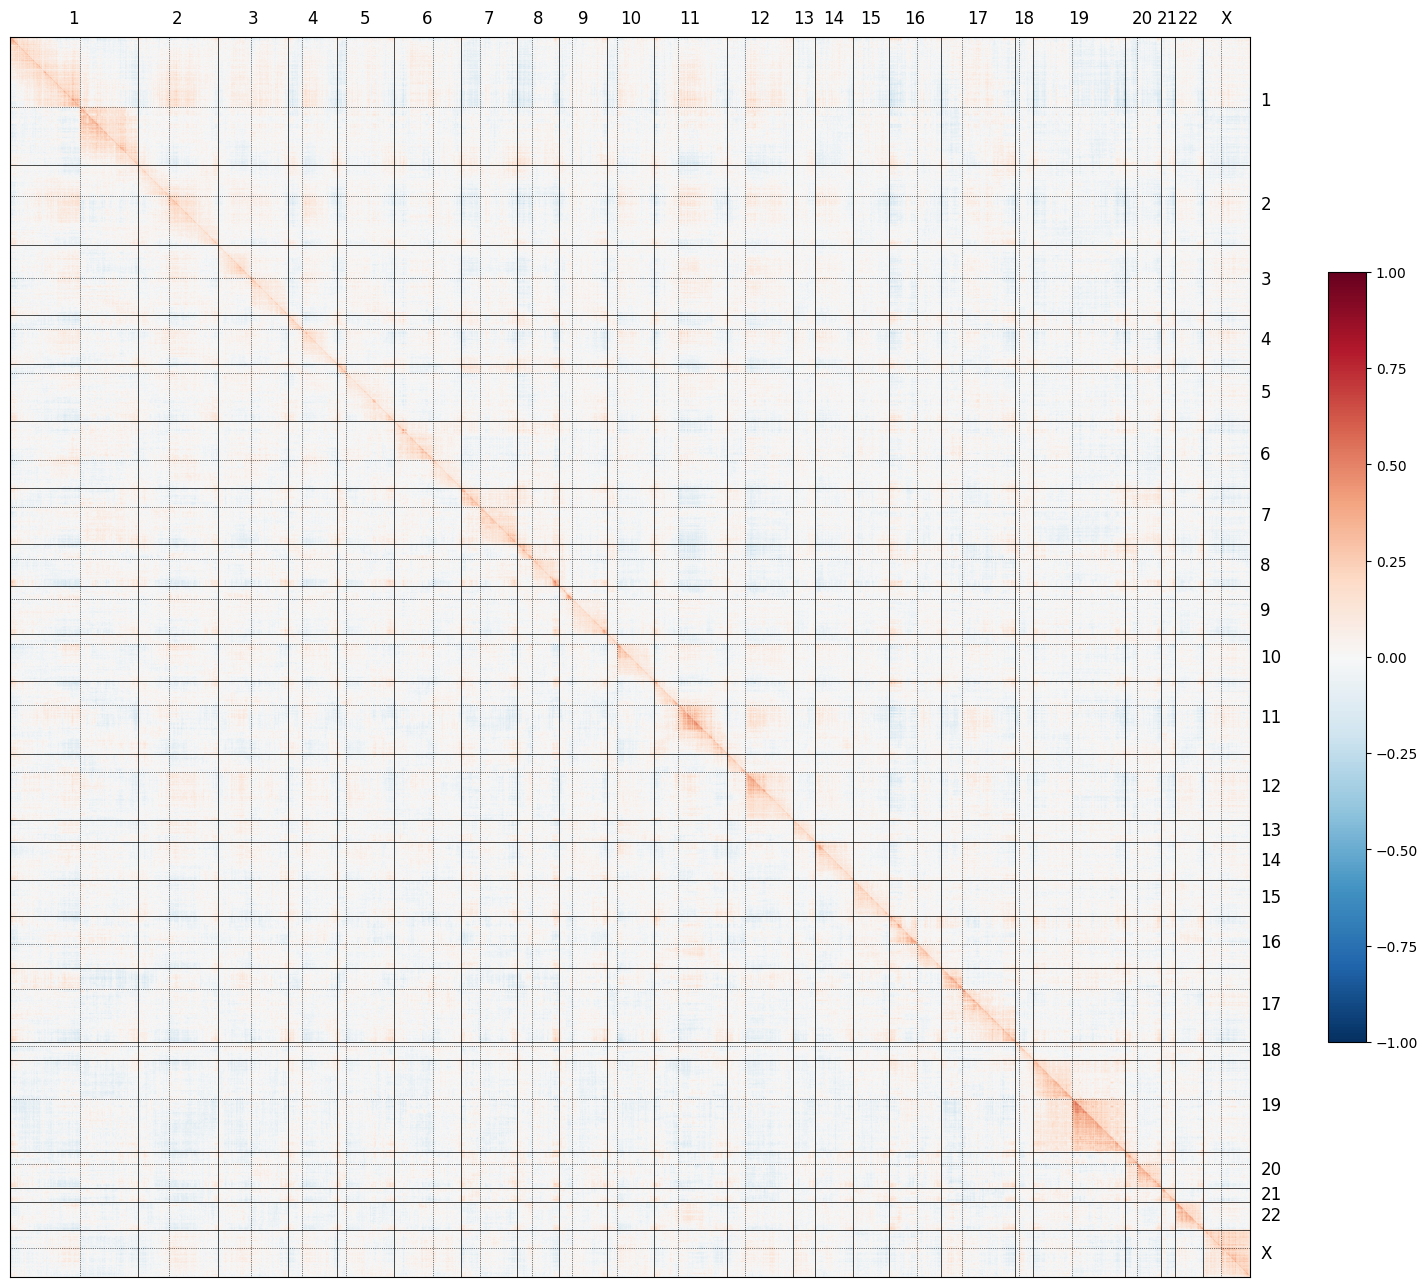

In [70]:
split_mat_norm = make_split_cosmat(tp53_wt_mat_norm, tp53_lof_mat_norm)
print('DepMap 22Q4q3 quantile normalized - TP53 WT (upper) LoF (lower)')
plot_heatmap(split_mat_norm, f_name=os.path.join(path, 'DepMap_22Q4_TP53_split_wt_vs_lof.svg'), format='svg', crunch_factor=10, title='')

# Quantify the proximity bias with Brunner-Munzel statistics

In [65]:
from proxbias.metrics import bm_metrics
from proxbias.plotting.bm_bars import plot_bm_bar_pairs

In [62]:
# Setting sample fraction helps avoid memory issues
tp53_wt_bm_all, tp53_wt_bm_arm = bm_metrics(tp53_wt_mat_norm, verbose=False, sample_frac=0.1)
tp53_lof_bm_all, tp53_lof_bm_arm = bm_metrics(tp53_lof_mat_norm, verbose=False, sample_frac=0.1)

In [63]:
tmp1 = tp53_wt_bm_arm.copy()
tmp1.index.name = 'Chromosome arm'
tmp1 = tmp1.assign(Condition = 'TP53 WT')
tmp1 = tmp1.reset_index().set_index(['Condition', 'Chromosome arm'])

tmp2 = tp53_lof_bm_arm.copy()
tmp2.index.name = 'Chromosome arm'
tmp2 = tmp2.assign(Condition = 'TP53 LoF')
tmp2 = tmp2.reset_index().set_index(['Condition', 'Chromosome arm'])

arm_stats_df = pd.concat([tmp1, tmp2])

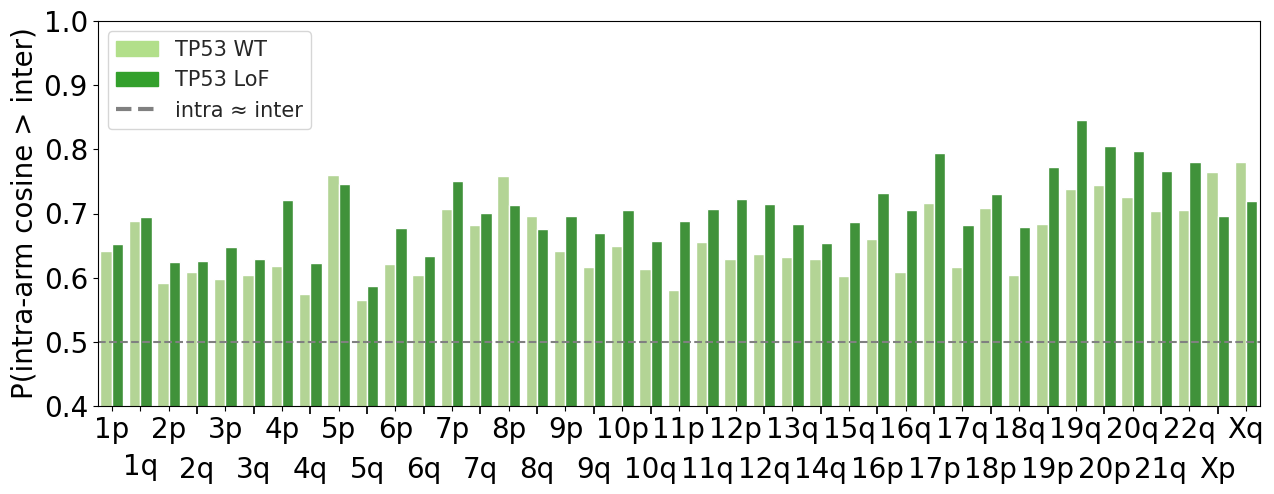

In [71]:
tmp = arm_stats_df
tmp = tmp.reset_index().rename(columns={'prob':'P(intra-arm cosine > inter)'})
tmp = pd.concat([tmp.query('Condition=="TP53 WT"'),
                 tmp.query('Condition=="TP53 LoF"')])
plot_bm_bar_pairs(tmp, x='Chromosome arm', y='P(intra-arm cosine > inter)', hue='Condition', 
                  lab1='TP53 WT', lab2='TP53 LoF', i=1, legend_loc='upper left',
                  f_name=os.path.join(path, 'tp53_split_bars.svg'))

# Look at the difference in prox bias for selected genes in the TP53 LoF background

In [76]:
sel_genes = [('CDKN2A', 'lof_vs_wt'),
             ('CDKN2B', 'lof_vs_wt'),
             ('CDKN2C', 'gof_vs_wt'),
             ('MDM4', 'gof_vs_wt'),
             ('BTG2', 'gof_vs_wt')]

In [80]:
def split_norm_mats(gene, tp53_bg_cl, split_type='lof_vs_wt',
                    cnv_data=cnv_data, mutation_data=mutation_data):
    lof_models, wt_models, gof_models, _ = split_models(
        gene_symbol=g,
        candidate_models=tp53_bg_cl,
        cnv_data=cnv_data,
        mutation_data=mutation_data
    )

    if split_type in ('lof_vs_wt', 'lof_vs_gof'):
        mat1 = make_pairwise_cos(dm22q4.loc[:,lof_models])

    if split_type == 'gof_vs_wt':
        mat1 = make_pairwise_cos(dm22q4.loc[:,gof_models])

    if split_type in ('lof_vs_wt', 'gof_vs_wt'):
        mat2 = make_pairwise_cos(dm22q4.loc[:,wt_models])

    if split_type == 'lof_vs_gof':
        mat2 = make_pairwise_cos(dm22q4.loc[:,gof_models])

    return mat1, mat2

In [81]:
arm_stats_d = {}

In [82]:
bg = 'p53_lof'
for g, split_type in sel_genes:
    print(g, split_type)
    if (g, split_type) in arm_stats_d:
        continue
    if bg == 'p53_lof':
        models = tp53_lof_models
    if bg == 'p53_wt':
        models = tp53_wt_models

    if split_type == 'lof_vs_wt':
        lab1 = f'{g} LOF'
        lab2 = f'{g} WT'
    if split_type == 'gof_vs_wt':
        lab1 = f'{g} GOF'
        lab2 = f'{g} WT'

    mat1_norm, mat2_norm = split_norm_mats(gene=g, tp53_bg_cl=models, split_type=split_type)

    mat1_bm_all, mat1_bm_arm = bm_metrics(mat1_norm, verbose=False, sample_frac=0.1)
    mat2_bm_all, mat2_bm_arm = bm_metrics(mat2_norm, verbose=False, sample_frac=0.1)

    tmp1 = mat1_bm_arm.copy()
    tmp1.index.name = 'Chromosome arm'
    tmp1 = tmp1.assign(Condition = lab1)
    tmp1 = tmp1.reset_index().set_index(['Condition', 'Chromosome arm'])

    tmp2 = mat2_bm_arm.copy()
    tmp2.index.name = 'Chromosome arm'
    tmp2 = tmp2.assign(Condition = lab2)
    tmp2 = tmp2.reset_index().set_index(['Condition', 'Chromosome arm'])

    arm_stats_df_tmp = pd.concat([tmp1, tmp2])
    arm_stats_d[(g, split_type)] = [arm_stats_df_tmp, mat1_bm_all, mat2_bm_all]
    print('done w/ analysis')

CDKN2A lof_vs_wt
done w/ analysis
CDKN2B lof_vs_wt
done w/ analysis
CDKN2C gof_vs_wt
done w/ analysis
MDM4 gof_vs_wt
done w/ analysis
BTG2 gof_vs_wt
done w/ analysis


CDKN2A lof_vs_wt
CDKN2B lof_vs_wt
CDKN2C gof_vs_wt
MDM4 gof_vs_wt
BTG2 gof_vs_wt


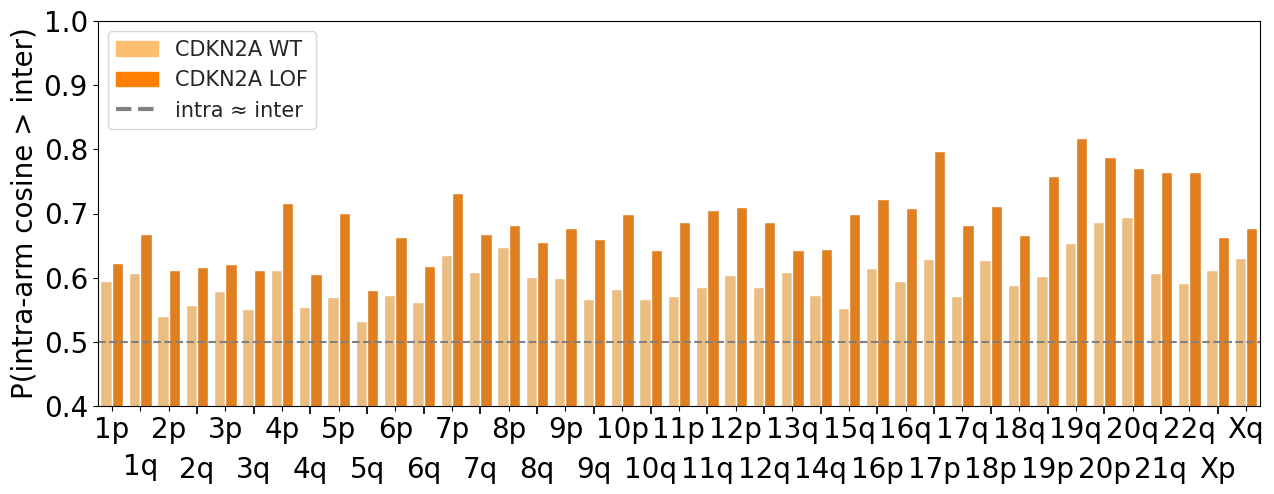

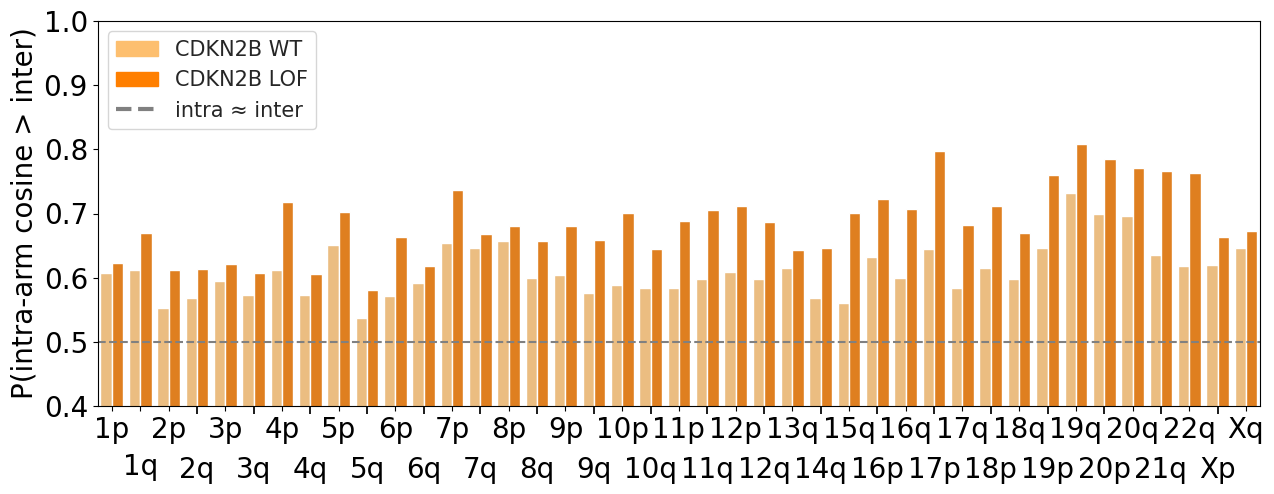

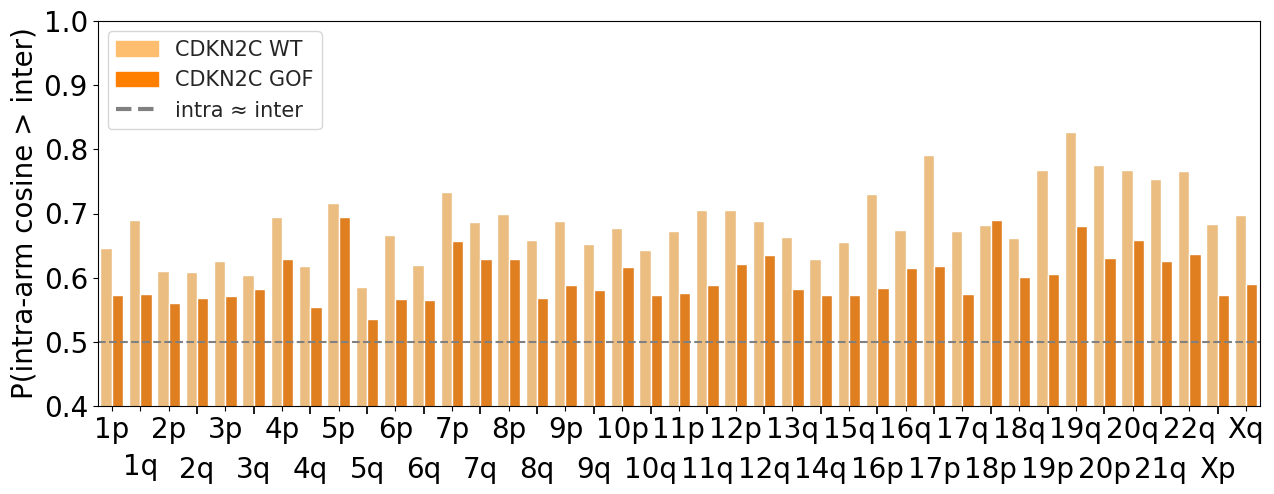

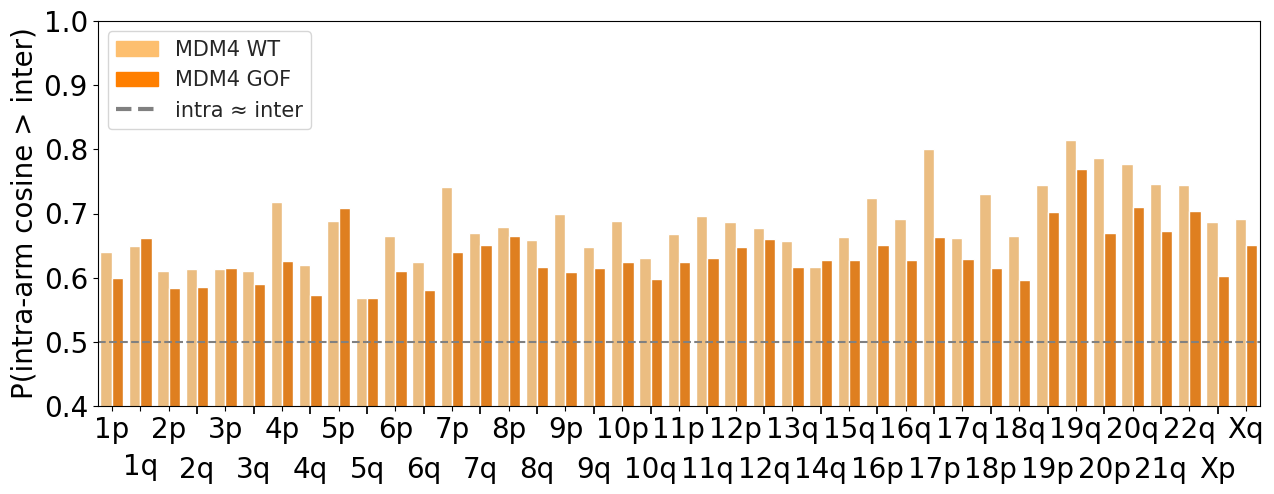

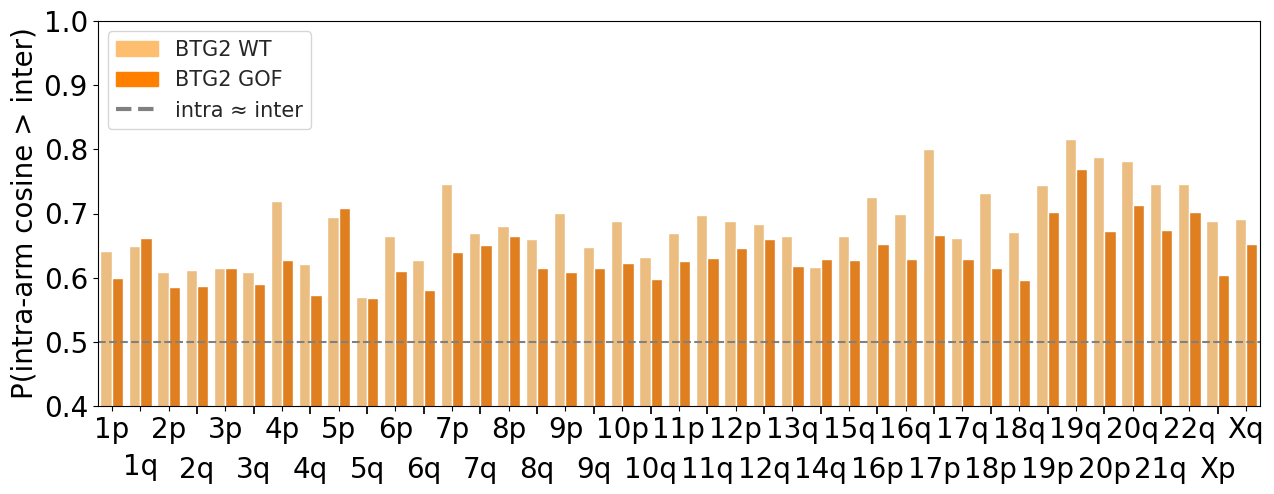

In [85]:
for g, split_type in arm_stats_d:
    print(g, split_type)

    if split_type == 'lof_vs_wt':
        lab1 = f'{g} WT'
        lab2 = f'{g} LOF'
    if split_type == 'gof_vs_wt':
        lab1 = f'{g} WT'
        lab2 = f'{g} GOF'

    tmp = arm_stats_d[(g, split_type)][0]
    tmp = tmp.reset_index().rename(columns={'prob':'P(intra-arm cosine > inter)'})
    tmp = pd.concat([tmp.query('Condition==@lab1'),
                     tmp.query('Condition==@lab2')])
    plot_bm_bar_pairs(tmp, x='Chromosome arm', y='P(intra-arm cosine > inter)', hue='Condition', 
                      lab1=lab1, lab2=lab2, i=3, legend_loc='upper left',
                      f_name=os.path.join(path, f'{g}_{split_type}_bars.svg'))